# t-SNE for data exploration

The algorithm (t-Distributed Stochastic Neighbor Embedding) can be used to describe high dimensional relationships in a lower dimension. This can be useful in data exploration for identifying things like clusters or other patterns in the data representation. The representation here will be vectors found by FastText for documents in a set.

The data will be decisions (uitspraken) put out by the Dutch Supreme Court (De Hoge Raad). These documents are available freely online and have already been labeled for some information on the type of case being handled and which branch of the judicial system handled the case.

### SETUP
Change directory to the `src` directory because most of the paths currently assume that location.

In [1]:
%cd ..

/Users/davidvalpey/practice/nlp_experiments/src


Imports for running the following code. The `ipywidgets` package is what allows us to do interactive refactoring for the t-SNE exploration.

In [12]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from matplotlib import offsetbox
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from time import time
from uitspraak_files.extract_from_xmls import parse_xmls
%matplotlib inline

Load and parse XML files. We drop the text field here because we won't need it, and it makes the objects easier to read later.

In [3]:
parsed_docs = list(parse_xmls())
for doc in parsed_docs:
    del doc["text"]
parsed_docs[0]

{'identifier': 'ECLI:NL:GHARL:2020:2395',
 'format': 'text/xml',
 'accessRights': 'public',
 'modified': '2020-03-20T00:01:04',
 'issued': '2020-03-19',
 'publisher': 'Raad voor de Rechtspraak',
 'language': 'nl',
 'creator': 'Gerechtshof Arnhem-Leeuwarden',
 'date': '2020-03-19',
 'zaaknummer': 'ISD P19/0295',
 'type': 'Uitspraak',
 'procedure': 'Beschikking',
 'coverage': 'NL',
 'spatial': 'Arnhem',
 'subject': 'Strafrecht',
 'relation': 'Eerste aanleg: ECLI:NL:RBDHA:2019:8927, (Gedeeltelijke) vernietiging en zelf afgedaan',
 'hasVersion': ['Rechtspraak.nl'],
 'file_id': 'ECLI_NL_GHARL_2020_2395',
 'title': 'ECLI:NL:GHARL:2020:2395 Gerechtshof Arnhem-Leeuwarden , 19-03-2020 / ISD P19/0295',
 'abstract': ['Het hoger beroep tegen een beslissing tot tenuitvoerlegging van een voorwaardelijk opgelegde ISD-maatregel (38 r Sr en 509ff Sv) ingesteld voor 1 januari 2020 en de Wet USB.',
  'Artikel 5 EVRM brengt met zich mee dat als de mogelijkheid van hoger beroep is opengesteld en tijdig hog

This data set has multiple categorical fields that could be used for classification. For the sake of simplicity, we'll pick on that has a smaller number of of possible label. The legal domain in this case identifies the kind of law that applies.

In [4]:
Counter(doc.get('legal_domain') for doc in parsed_docs)

Counter({'Strafrecht': 2251,
         'Civiel recht': 3224,
         'Bestuursrecht': 3774,
         'Internationaal publiekrecht': 20})

### Simple application
The t-SNE solution in Scikit Learn is easy to apply and display. It only takes about one line of code to learn and apply a lower dimenional representation of the data. In this example we will take 100-dimensional word vectors and display them in a 2-dimensional grid. The colors will represent a classification on the type of case being represented.

First, we'll plot a simple PCA next to the results from t-SNE to compare the results.

In [5]:
inputs = [doc['doc_vector'] for doc in parsed_docs]
labels = [doc.get('legal_domain') for doc in parsed_docs]

In [6]:
pca0 = time()
X_pca = TruncatedSVD(n_components=2).fit_transform(inputs)
pca_time = time() - pca0

In [7]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
tsne0 = time()
X_tsne = tsne.fit_transform(inputs)
tsne_time = time() - tsne0

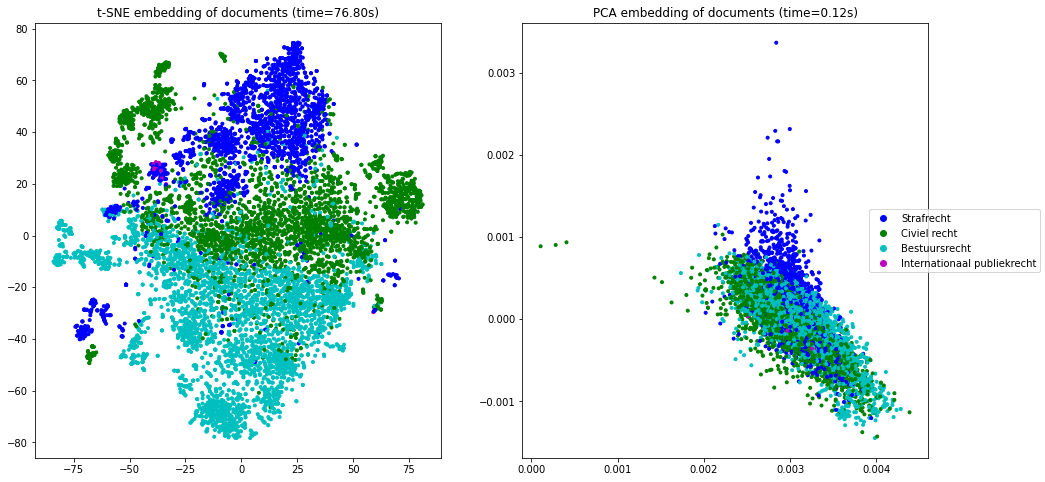

In [8]:
pca_xy = list(zip(*X_pca))
tsne_xy = list(zip(*X_tsne))

classes = ['Strafrecht', 'Civiel recht', 'Bestuursrecht', 'Internationaal publiekrecht']
color_names = ListedColormap(['b', 'g', 'c', 'm'])
color_mapping = {'Strafrecht': 0,
                 'Civiel recht': 1,
                 'Bestuursrecht': 2,
                 'Internationaal publiekrecht': 3}
colors = [color_mapping[doc.get('legal_domain')] for doc in parsed_docs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

scatter1 = ax1.scatter(tsne_xy[0], tsne_xy[1], c=colors, cmap=color_names, marker=".")
ax1.set_title(f"t-SNE embedding of documents (time={tsne_time:.2f}s)")

scatter2 = ax2.scatter(pca_xy[0], pca_xy[1], c=colors, cmap=color_names, marker=".")
ax2.set_title(f"PCA embedding of documents (time={pca_time:.2f}s)")
fig.legend(handles=scatter2.legend_elements()[0], labels=classes, loc="center right")
plt.show()

### 3d views
From the above image, it looks like there might not be a clear partition of the data. It's hard to tell if the colored sections truly merge, or if they might be superimposed over each when viewed from a higher dimensional space.
It is possible to rotate this image (disabled because it was too much for my machine at this scale) and see the data separated into colored bands in the 3rd dimension.

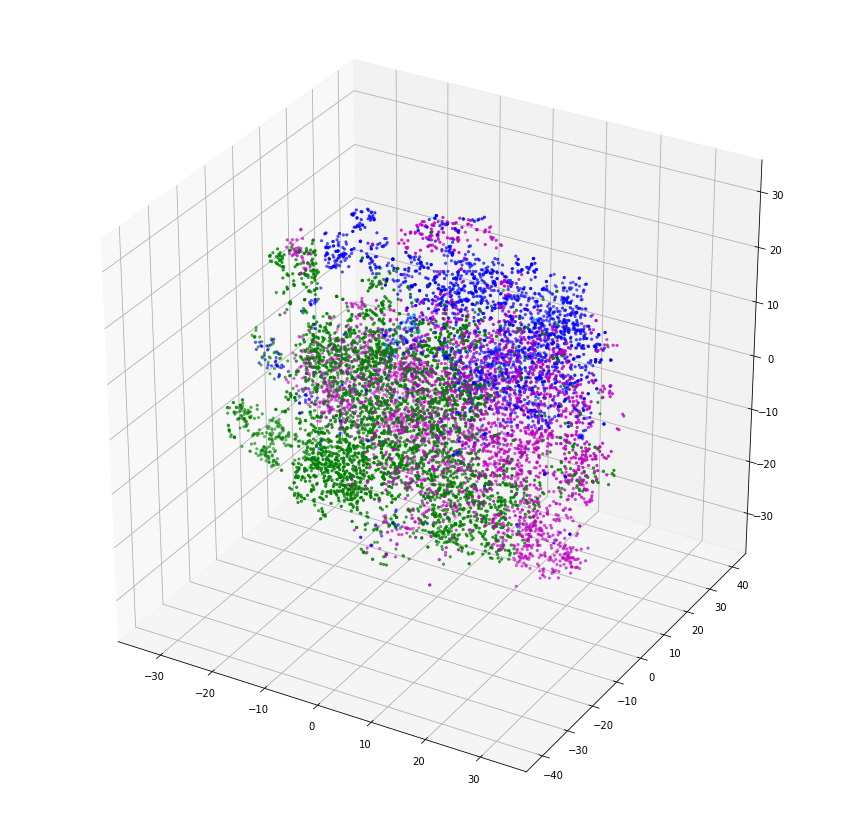

In [21]:
tsne_3d = TSNE(n_components=3, init='pca', random_state=0, n_jobs=-1)
tsne0_3d = time()
X_tsne_3d = tsne_3d.fit_transform(inputs)
tsne_time_3d = time() - tsne0_3d

tsne_xyz = list(zip(*X_tsne_3d))
classes = ['Strafrecht', 'Civiel recht', 'Bestuursrecht', 'Internationaal publiekrecht']
color_names = ListedColormap(['b', 'm', 'g', 'c'])
color_mapping = {'Strafrecht': 0,
                 'Civiel recht': 1,
                 'Bestuursrecht': 2,
                 'Internationaal publiekrecht': 3}
colors = [color_mapping[doc.get('legal_domain')] for doc in parsed_docs]

fig_3d = plt.figure(figsize=(15.0, 15.0))
ax_3d = fig_3d.add_subplot(111, projection='3d')

scatter_3d = ax_3d.scatter(xs=tsne_xyz[0], ys=tsne_xyz[1], zs=tsne_xyz[2], 
                        c=colors, cmap=color_names, marker=".", depthshade=True)
fig.legend(handles=scatter_3d.legend_elements()[0], labels=classes, loc="center right")
plt.show()

### t-SNE + PCA
So, one problem with t-SNE is that it scales quadratically with the number of features (O(n^2)). So feature reduction with this method works best with a lower number of features. It turns out that ~50 is a good number. It also happens that we can use another method like PCA to reduce our feature space before applying t-SNE, and this won't even have much effect on the final view of the data.
Below is a comparison of the results of t-SNE by itself (from above) and the combined results of t-SNE + PCA.

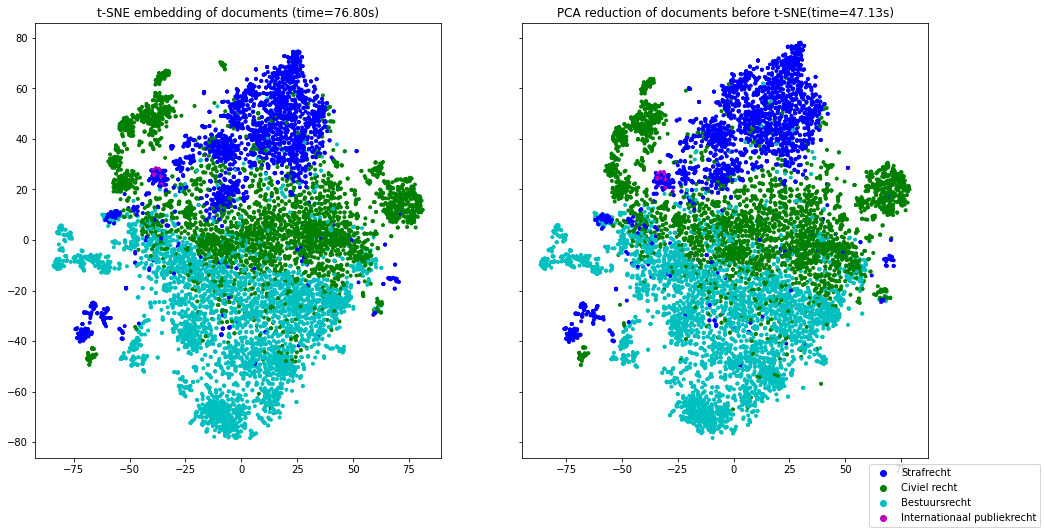

In [20]:
pca0_50 = time()
X_pca_50 = PCA(n_components=50).fit_transform(inputs)
pca_time_50 = time() - pca0

tsne_50 = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1)
tsne0_50 = time()
X_tsne_50 = tsne_50.fit_transform(X_pca_50)
tsne_time_50 = time() - tsne0_50

tsne_xy_50 = list(zip(*X_tsne_50))

classes = ['Strafrecht', 'Civiel recht', 'Bestuursrecht', 'Internationaal publiekrecht']
color_names = ListedColormap(['b', 'g', 'c', 'm'])
color_mapping = {'Strafrecht': 0,
                 'Civiel recht': 1,
                 'Bestuursrecht': 2,
                 'Internationaal publiekrecht': 3}
colors = [color_mapping[doc.get('legal_domain')] for doc in parsed_docs]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

scatter1 = ax1.scatter(tsne_xy[0], tsne_xy[1], c=colors, cmap=color_names, marker=".")
ax1.set_title(f"t-SNE embedding of documents (time={tsne_time:.2f}s)")

scatter2 = ax2.scatter(tsne_xy_50[0], tsne_xy_50[1], c=colors, cmap=color_names, marker=".")
ax2.set_title(f"PCA reduction of documents before t-SNE (time={tsne_time_50:.2f}s)")
fig.legend(handles=scatter2.legend_elements()[0], labels=classes, loc="lower right")
plt.show()

In [17]:
print(tsne_time, tsne_time_50)

76.79723381996155 45.35313606262207


### Interactive exploration
So great, in a short amount of time we can have several pretty looking plots of our data. What's wrong with that?

We've barely touched any of the pramaters for the algorithm, and these can have a huge impact on what the results look like.
* n_components: int, optional (default: 2)
* perplexity: float, optional (default: 30)
* early_exaggeration: float, optional (default: 12.0)
* learning_rate: float, optional (default: 200.0)
* n_iter: int, optional (default: 1000)

For one thing, understanding the results often requires viewing the data after applying multiple perplexity values. The best way to learn to read t-SNE plots is to try out a number of different parameters and see what effect they have. It is possible that our data would separate clearly even in a 2d plot given the right combination of parameters. 

Perplexity affects the influence that local and global distance have over the final results, and can completely change the representation. Rather than change these parameters individually, we can do a crossvalidation and plot all the results, picking one that shows the divisions we're looking for in the data. Or we can use interactive widgets to iterate through variations in our parameters.

For this, we need to define a function that exposes all the parameters we would like to explore. The PCA step will be included before this step to reduce the time needed to retrain after each change. For now we will just add perplexity and the number of iterations (n_iter) for this example.

In [36]:
pca0_interactive = time()
X_pca_interactive = PCA(n_components=50).fit_transform(inputs)
pca_time_interactive = time() - pca0_interactive

classes = ['Strafrecht', 'Civiel recht', 'Bestuursrecht', 'Internationaal publiekrecht']
color_names = ListedColormap(['b', 'g', 'c', 'm'])
color_mapping = {'Strafrecht': 0,
                 'Civiel recht': 1,
                 'Bestuursrecht': 2,
                 'Internationaal publiekrecht': 3}
colors = [color_mapping[doc.get('legal_domain')] for doc in parsed_docs]


In [41]:
@interact(data=widgets.fixed(X_pca_interactive),
         perplexity=widgets.IntSlider(min=5, max=100, step=5, value=30),
         n_iter=widgets.IntSlider(min=500, max=5000, step=50, value=500)
         )
def explore_tsne(data, perplexity, n_iter):
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter,
                init='pca', random_state=0, n_jobs=-1)
    tsne0 = time()
    X_tsne = tsne.fit_transform(data)
    tsne_time = time() - tsne0

    tsne_xy = list(zip(*X_tsne))

    fig = plt.figure(figsize=(15.0, 15.0))
    ax = fig.add_subplot(111)
    ax.set_title(f"t-SNE embedding of documents (time={tsne_time:.2f}s)")

    scatter = ax.scatter(tsne_xyz[0], tsne_xyz[1], 
                         c=colors, cmap=color_names, marker=".")
    fig.legend(handles=scatter.legend_elements()[0], labels=classes, loc="lower right")
    plt.show()

interactive(children=(IntSlider(value=30, description='perplexity', min=5, step=5), IntSlider(value=500, descr…

As a reminder, below is the default version of this plot.

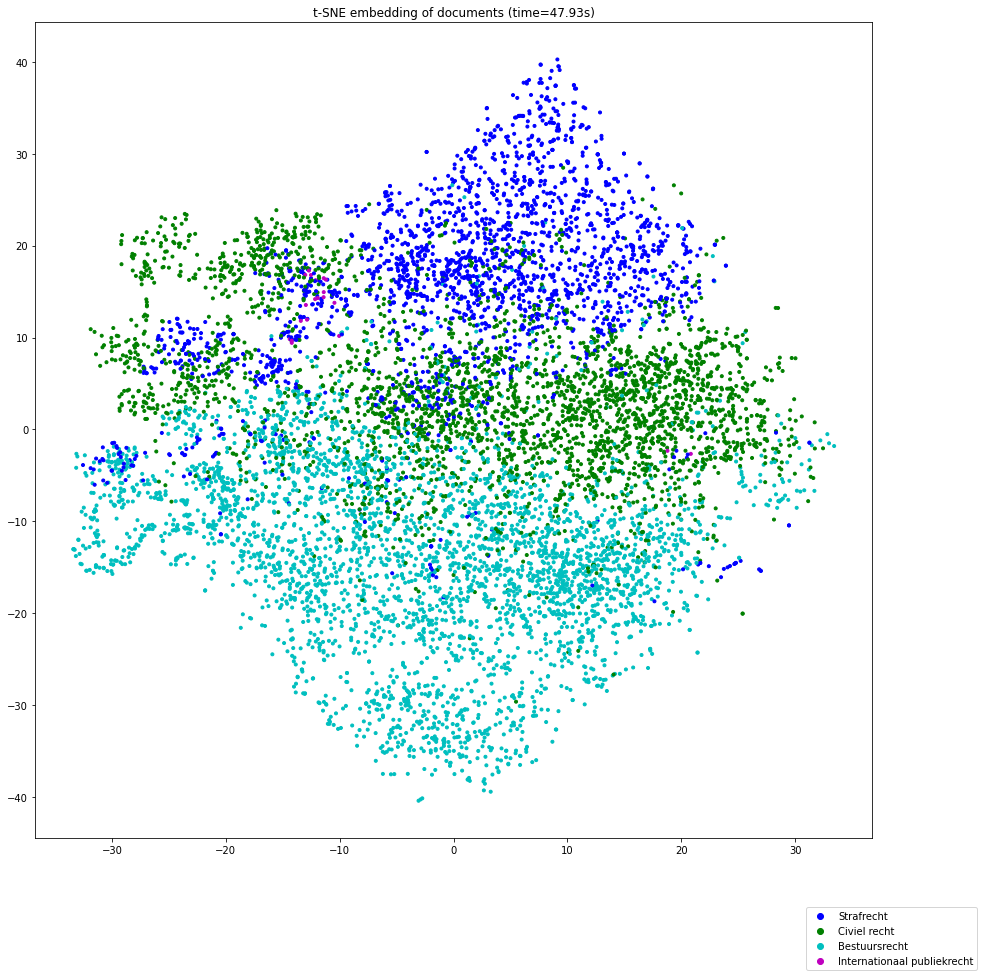

In [42]:
explore_tsne(X_pca_interactive, 30, 1000)